In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import Parameter
import torch.utils.data as Data
from torch.utils.data import RandomSampler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
import pennylane as qml
import pytorch_lightning as pl
import math
from Factory import Window_that_slides, QShallowRegressionLSTM, QRegressionLSTM
from sklearn.preprocessing import StandardScaler
from pyqpanda import *


In [2]:
dfi = pd.read_csv('./kaggle/city_hour.csv')
dfi

,City,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01 01:00:00,NaN,NaN,1.00,40.01,36.37,NaN,1.00,122.07,NaN,0.0,0.0,0.0,NaN,NaN
1,Ahmedabad,2015-01-01 02:00:00,NaN,NaN,0.02,27.75,19.73,NaN,0.02,85.90,NaN,0.0,0.0,0.0,NaN,NaN
2,Ahmedabad,2015-01-01 03:00:00,NaN,NaN,0.08,19.32,11.08,NaN,0.08,52.83,NaN,0.0,0.0,0.0,NaN,NaN
3,Ahmedabad,2015-01-01 04:00:00,NaN,NaN,0.30,16.45,9.20,NaN,0.30,39.53,153.58,0.0,0.0,0.0,NaN,NaN
4,Ahmedabad,2015-01-01 05:00:00,NaN,NaN,0.12,14.90,7.85,NaN,0.12,32.63,NaN,0.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707870,Visakhapatnam,2020-06-30 20:00:00,9.50,36.00,2.75,25.57,15.85,4.57,0.62,NaN,27.75,NaN,NaN,NaN,51.0,Satisfactory
707871,Visakhapatnam,2020-06-30 21:00:00,17.25,49.25,3.62,33.20,20.62,3.78,0.76,2.02,25.58,NaN,NaN,NaN,51.0,Satisfactory
707872,Visakhapatnam,2020-06-30 22:00:00,36.00,71.00,2.20,30.80,18.20,3.67,0.58,1.77,26.15,NaN,NaN,NaN,50.0,Good
707873,Visakhapatnam,2020-06-30 23:00:00,15.75,63.00,1.02,28.90,16.00,3.80,0.49,0.75,15.82,NaN,NaN,NaN,50.0,Good


In [3]:
dfi.dropna()
df = dfi.loc[ dfi['City'] == 'Delhi']  #will be using the delhi data first for simplicity
df = df.loc[df['Datetime'] < '2016-01-01 00:00:00']
df = df.dropna()

In [4]:
df = df.reset_index()
df = df.drop(['index','City','AQI_Bucket','Datetime','SO2', 'O3','Benzene','Toluene','Xylene','NO','NOx','NH3','NO2'], axis=1)
df

,PM2.5,PM10,CO,AQI
0,211.51,340.66,15.24,456.0
1,191.12,257.40,13.11,450.0
2,218.44,351.01,18.35,446.0
3,296.80,600.95,16.67,475.0
4,336.43,714.63,12.17,480.0
...,...,...,...,...
4944,142.61,359.15,2.64,412.0
4945,201.88,464.06,3.79,415.0
4946,272.73,535.32,2.89,432.0
4947,271.46,518.95,3.02,433.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4949 entries, 0 to 4948
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PM2.5   4949 non-null   float64
 1   PM10    4949 non-null   float64
 2   CO      4949 non-null   float64
 3   AQI     4949 non-null   float64
dtypes: float64(4)
memory usage: 154.8 KB


In [6]:
size = int(len(df) * 0.8)

train = df.iloc[:size].copy()
test = df.iloc[size:].copy()
train

,PM2.5,PM10,CO,AQI
0,211.51,340.66,15.24,456.0
1,191.12,257.40,13.11,450.0
2,218.44,351.01,18.35,446.0
3,296.80,600.95,16.67,475.0
4,336.43,714.63,12.17,480.0
...,...,...,...,...
3954,181.59,378.51,2.88,437.0
3955,183.38,347.46,2.49,432.0
3956,170.97,276.65,2.07,424.0
3957,160.19,243.97,1.56,414.0


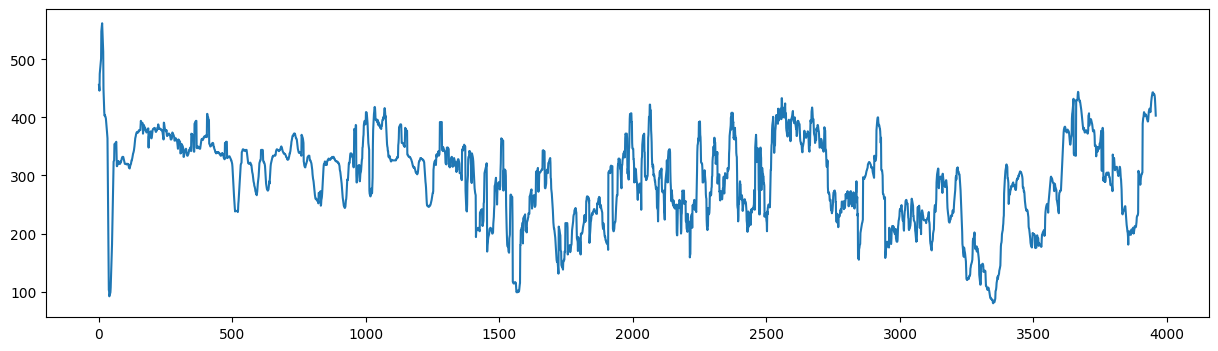

In [7]:
%matplotlib inline
plt.figure(figsize=(15, 4))
plt.plot(range(len(train)), train["AQI"])
plt.show()

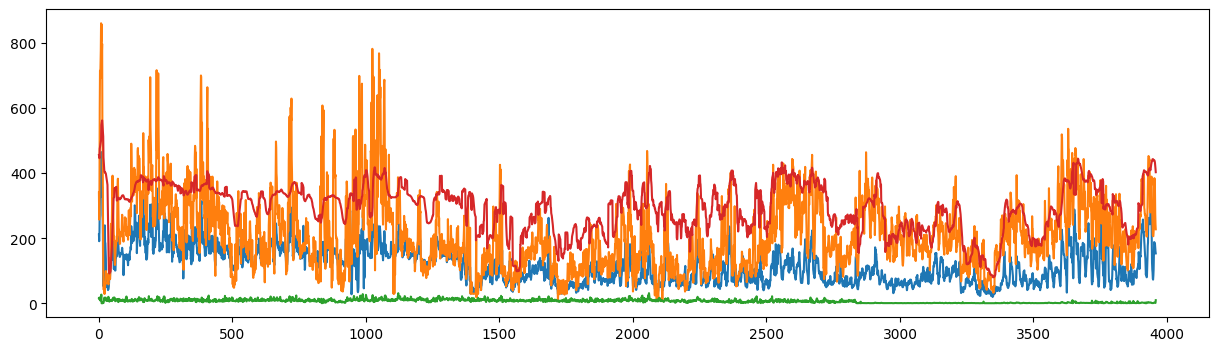

In [8]:
plt.figure(figsize=(15, 4))
plt.plot(train)
plt.show()

In [9]:
def data_process(data, window_size, predict_size):
    scaler = StandardScaler()
    data = scaler.fit_transform(np.array(data).reshape(-1, 1))
    
    data_in = []
    data_out = []
    
    for i in range(data.shape[0] - window_size - predict_size + 1):
        data_in.append(data[i:i + window_size].reshape(1, window_size)[0])
        data_out.append(data[i + window_size:i + window_size + predict_size].reshape(1, predict_size)[0])
        
    data_in = np.array(data_in).reshape(-1, window_size)
    data_out = np.array(data_out).reshape(-1, predict_size)
    
    data_process = {'datain': data_in, 'dataout': data_out}
    
    return data_process, scaler

In [10]:
features_size = 4
window_size = features_size * 3
predict_size = features_size

In [11]:
train_processed, train_scaler = data_process(train, window_size, predict_size)
X_train, y_train = train_processed['datain'], train_processed['dataout']

test_processed, test_scaler = data_process(test, window_size, predict_size)
X_test, y_test = test_processed['datain'], test_processed['dataout']

In [12]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))

y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

In [13]:
import torch.utils.data as Data

train_data = Data.TensorDataset(X_train, y_train)
test_data = Data.TensorDataset(X_test, y_test)

print(f'size of train_data: {len(train_data)}')
print(f'size of test_data: {len(test_data)}')

size of train_data: 15821
size of test_data: 3945


In [14]:
train_data[0]

(tensor([ 0.4188,  1.4134, -1.0927,  2.3017,  0.2618,  0.7722, -1.1091,  2.2555,
          0.4722,  1.4931, -1.0687,  2.2247]),
 tensor([ 1.0757,  3.4180, -1.0817,  2.4480]))

In [15]:
test_data[0]

(tensor([-0.4356, -0.0561, -1.3520,  0.9249, -0.4470, -0.0389, -1.3648,  0.8839,
         -0.4170,  0.0479, -1.3594,  0.8546]),
 tensor([-0.2321,  0.4513, -1.3671,  0.8312]))

In [16]:
class InitQMachine:
    def __init__(self, qubitsCount, cbitsCount = 0, machineType = QMachineType.CPU):
        self.machine = init_quantum_machine(machineType)
        
        self.qubits = self.machine.qAlloc_many(qubitsCount)
        self.cbits = self.machine.cAlloc_many(cbitsCount)
        
        print(f'Init Quantum Machine with qubits:[{qubitsCount}] / cbits:[{cbitsCount}] Successfully')
    
    def __del__(self):
        destroy_quantum_machine(self.machine)

ctx = InitQMachine(5)

def draw(prog, filename=''):
    dir_path = './images/'
    
    if filename != '':
        draw_qprog(prog, 'pic', filename=f'{dir_path}{filename}')

class QuantumLayerBase(nn.Module):
    def __init__(self, input_size, output_size, *, n_qubits, n_layers = 1, ctx = None):
        super(QuantumLayerBase, self).__init__()
        
        self.data = None # need to input during forward
    
        self.input_size = input_size
        self.output_size = output_size # hidden size, not n_qubits
        
        # quantum infos
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        
        self.ctx = ctx
        self.qubits = ctx.qubits
        self.machine = ctx.machine
        
        # convert quantum input/output to match classical computation
        self.qin = nn.Linear(self.input_size, self.n_qubits)
        self.qout = nn.Linear(self.n_qubits, self.output_size)
        
    @property
    def circuit(self):
        raise NotImplementedError('Should init circuit')

def measure(self):
    HamiZ = [ PauliOperator({f'Z{i}': 1}) for i in range(len(self.qubits)) ]
    res = [ eval(qop(self.circuit, Hami, self.machine, self.qubits))[0,0] for Hami in HamiZ ]
    
    return Parameter(Tensor(res[:self.n_qubits]))

QuantumLayerBase.measure = measure

def forward(self, inputs):
    y_t = self.qin(Parameter(inputs))
    self.data = y_t[0]
    
    return self.qout(self.measure())

QuantumLayerBase.forward = forward

class QuantumLayer(QuantumLayerBase):
    def __init__(self, input_size, output_size, *, n_qubits, degree = 1, n_layers = 1, ctx = None):
        super(QuantumLayer, self).__init__(input_size, output_size, 
                                         n_qubits = n_qubits, n_layers = n_layers, ctx = ctx)
        
        self.degree = degree
        self.angles = Parameter(torch.rand(n_layers + 1, degree, self.n_qubits))
        
    @property
    def qparameters_size(self):
        return self.angles.flatten().size()[0]
        
    @property
    def circuit(self):
        if self.data == None:
            raise ValueError('Need to feed a input data!')
        
        n = self.n_qubits
        q = self.qubits
        x = self.data
        p = self.angles
        degree = self.degree
        
        # quantum gates - must use small case!
        identity = VariationalQuantumGate_I
        h = VariationalQuantumGate_H
        ry = VariationalQuantumGate_RY
        cz = VariationalQuantumGate_CZ
        u = [
            None,
            VariationalQuantumGate_U1,
            VariationalQuantumGate_U2,
            VariationalQuantumGate_U3
        ]
        
        # init variational quantum circuit
        vqc = VariationalQuantumCircuit()

        # in order to use each qubits => when n_qubits < len(ctx.qubits)
        [ vqc.insert(identity(q[i])) for i in range(len(q)) ]
        
        [ vqc.insert( h(q[i]) ) for i in range(n) ]
        [ vqc.insert( ry(q[i], var(x[i] * torch.pi/2)) ) for i in range(n) ]
        [ vqc.insert( u[degree](q[i], *[ var(p[0][d][i]) for d in range(degree) ]) ) 
                 for i in range(n) ]
        
        for layer in range(self.n_layers):
            for i in range(n - 1):
                vqc.insert(cz(q[i], q[i + 1]))
            vqc.insert(cz(q[n - 1], q[0]))
            
            [ vqc.insert( u[degree](q[i], *[ var(p[layer + 1][d][i]) for d in range(degree) ]) ) 
                 for i in range(n) ]
        
        return vqc

class QLSTMBase(nn.Module):
    def __init__(self, input_size, hidden_size, *, ctx):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.ctx = ctx
        
    @property
    def qparameters_size(self):
        num = 0
        for attr in dir(self):
            if attr.endswith('_circuit'):
                num += getattr(self, attr).qparameters_size
        return num

def forward(self, inputs, init_states = None):
    sequence_size, batch_size, _ = inputs.size()
    hidden_sequence = []
    
    if init_states == None:
        h_t, c_t = (
            torch.zeros(1, batch_size, self.hidden_size).to(inputs.device),
            torch.zeros(1, batch_size, self.hidden_size).to(inputs.device),
        )
    else:
        h_t, c_t = init_states
    
    return hidden_sequence, (h_t, c_t)

QLSTMBase.forward = forward

class QLSTM(QLSTMBase):
    def __init__(self, input_size, hidden_size, *, ctx):
        super().__init__(input_size, hidden_size, ctx = ctx)
        
        # Parameters: angles
        #  => Q * (n + 1) * degree
        
        # gates names:  qubits  layers  degree
        # input gate:     5       2       3
        # forget gate:    5       2       3
        # candidate:      5       2       3
        # output gate:    5       2       3
        
        # input gates
        self.input_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                        n_qubits = 5, n_layers = 2, degree = 3, ctx = ctx) # 45
        # forget gates
        self.forget_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 5, n_layers = 2, degree = 3, ctx = ctx) # 45
        # candidate
        self.candidate_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                       n_qubits = 5, n_layers = 2, degree = 3, ctx = ctx) # 45
        # output gates
        self.output_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 5, n_layers = 2, degree = 3, ctx = ctx) # 45
        
    def forward(self, inputs, init_states = None):
        hidden_sequence, (h_t, c_t) = super(QLSTM, self).forward(inputs, init_states)

        for t in range(inputs.size()[0]):
            x_t = inputs[t, :, :]
            v_t = torch.cat((h_t[0], x_t), dim = 1)

            # input gates
            i_t = torch.sigmoid(self.input_circuit(v_t))
            # forget gates
            f_t = torch.sigmoid(self.forget_circuit(v_t))
            # candidate for cell state update
            g_t = torch.tanh(self.candidate_circuit(v_t))
            c_t = (f_t * c_t) + (i_t * g_t)

            # output gates
            o_t = torch.sigmoid(self.output_circuit(v_t))
            # update output ht
            h_t = o_t * (torch.tanh(c_t))

            hidden_sequence.append(h_t)

        # reshape hidden_seq p/ retornar
        #
        # [tensor([[[0.0444, ...]]] => tensor([[[0.0444, ...]]]
        # 
        hidden_sequence = torch.cat(hidden_sequence, dim = 0)

        return hidden_sequence, (h_t, c_t)

class StackedQLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, *, num_layers = 1, ctx = None, mode = 'classical'):
        super().__init__()

        self.qlstm = QLSTM(input_size, hidden_size, ctx = ctx)

    def forward(self, inputs, parameters = None):
        outputs = None
            
        outputs, parameters = self.qlstm(inputs, parameters)
        
        return outputs, parameters

class QModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_output, *, num_layers = 1, ctx = None, mode = 'classical'):
        super(QModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.mode = mode
        
        self.qlstm = StackedQLSTM(input_size, hidden_size, 
                                  num_layers = num_layers, ctx = ctx, mode = mode)
        self.predict = nn.Linear(hidden_size, num_output)

    def forward(self, x):
        x = x.unsqueeze(0)
        
        # sequence lenth , batch_size, features length
        # 
        h0 = torch.zeros(1, x.size(1), self.hidden_size)
        c0 = torch.zeros(1, x.size(1), self.hidden_size)
        
        out, _ = self.qlstm(x, (h0, c0))
        out = self.predict(out[0])
        
        return out

Init Quantum Machine with qubits:[5] / cbits:[0] Successfully


In [17]:
from torch.utils.data import RandomSampler

def train_model(model, datas, batch_size, *, loss_func, optimizer, epoch = 50, early_stop = False):
    losses = []
    sampler = RandomSampler(datas, num_samples = batch_size)
    
    last_loss = 0.0
    for step in range(epoch):
        train_loss = 0.0
        
        for index in sampler:
            batch_x, batch_y = datas[index][0], datas[index][1]
            b_x = batch_x.unsqueeze(0)
            b_y = batch_y.unsqueeze(0)
            
            output = model(b_x)

            loss = loss_func(output, b_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        loss = train_loss / batch_size
        if early_stop and loss < 0.0002:
            break
            
        last_loss = loss
        
        print(f'Epoch {step + 1}/{epoch}: Loss: {loss}')
        losses.append(loss)
    
    return losses

In [18]:
features_size = 4
window_size = features_size * 3 # 
predict_size = features_size # features

input_size = window_size
num_output = predict_size

hidden_size = 32
num_layers = 2

In [19]:
qmodel = QModel(input_size, hidden_size, num_output, 
                num_layers = num_layers, ctx = ctx, mode='GRU')
optimizer = torch.optim.Adam(qmodel.parameters(), lr = 0.0008)
loss_func = nn.MSELoss()

start = time.time()
losses = train_model(qmodel, train_data, batch_size=20,          
               loss_func = loss_func, optimizer = optimizer, epoch = 33, early_stop=True)
end = time.time()

print(f'time costs: {end - start}')

Epoch 1/33: Loss: 1.0835477873682975
Epoch 2/33: Loss: 0.9848482191562653
Epoch 3/33: Loss: 0.739630401134491
Epoch 4/33: Loss: 0.8149978742003441
Epoch 5/33: Loss: 0.9450907438993454
Epoch 6/33: Loss: 1.154826882481575
Epoch 7/33: Loss: 0.9077314823865891
Epoch 8/33: Loss: 0.7830080300569534
Epoch 9/33: Loss: 0.7785265579819679
Epoch 10/33: Loss: 0.6514656916260719
Epoch 11/33: Loss: 1.1641233086585998
Epoch 12/33: Loss: 1.1740906924009322
Epoch 13/33: Loss: 0.9054157495498657
Epoch 14/33: Loss: 1.1320503577589989
Epoch 15/33: Loss: 1.0081917092204093
Epoch 16/33: Loss: 0.9499812692403793
Epoch 17/33: Loss: 0.8928940787911415
Epoch 18/33: Loss: 0.8678532674908638
Epoch 19/33: Loss: 0.9766502305865288
Epoch 20/33: Loss: 0.7637347087264061
Epoch 21/33: Loss: 0.8498148933053017
Epoch 22/33: Loss: 0.838980607688427
Epoch 23/33: Loss: 0.6486908227205277
Epoch 24/33: Loss: 0.6347511753439903
Epoch 25/33: Loss: 0.7640029072761536
Epoch 26/33: Loss: 0.7048212453722954
Epoch 27/33: Loss: 0.789

In [20]:
results = []

for i in range(0, len(X_test), features_size):
    input_data = X_test[i:i+1]
    result = qmodel(input_data)
    result = train_scaler.inverse_transform(result.data)
    
    results.append(result[0])

In [59]:
test1 = pd.DataFrame(test, columns=('PM2.5',))
test1.reset_index(inplace=True,drop=True)
test2 = pd.DataFrame(test, columns=('PM10',))
test2.reset_index(inplace=True,drop=True)
test3 = pd.DataFrame(test, columns=('CO',))
test3.reset_index(inplace=True,drop=True)
test4 = pd.DataFrame(test, columns=('AQI',))
test4.reset_index(inplace=True,drop=True)
test4

,AQI
0,393.0
1,386.0
2,381.0
3,377.0
4,377.0
...,...
985,412.0
986,415.0
987,432.0
988,433.0


In [38]:
results = pd.DataFrame(results)
results.columns = ('PM2.5', 'PM10', 'CO', 'AQI')
results

,PM2.5,PM10,CO,AQI
0,131.429604,197.593777,111.159770,186.377758
1,130.432854,200.445678,109.562602,187.822965
2,127.950070,209.786954,102.843921,193.475809
3,126.324330,217.069806,96.894368,197.442400
4,126.365246,217.180631,96.301955,197.475154
...,...,...,...,...
982,130.795888,193.170581,114.259876,184.468637
983,128.747288,200.615712,109.812030,188.541536
984,125.158601,212.648027,101.132445,195.813746
985,122.221733,226.070426,91.013304,204.827400


In [39]:
result1 = pd.DataFrame(results, columns=('PM2.5', 'PM10', 'CO', 'AQI'))
result11 = pd.DataFrame(results, columns=('PM2.5',))
result12 = pd.DataFrame(results, columns=('PM10',))
result13 = pd.DataFrame(results, columns=('CO', ))
result2 = pd.DataFrame(results, columns=('AQI',))
result2

,AQI
0,186.377758
1,187.822965
2,193.475809
3,197.442400
4,197.475154
...,...
982,184.468637
983,188.541536
984,195.813746
985,204.827400


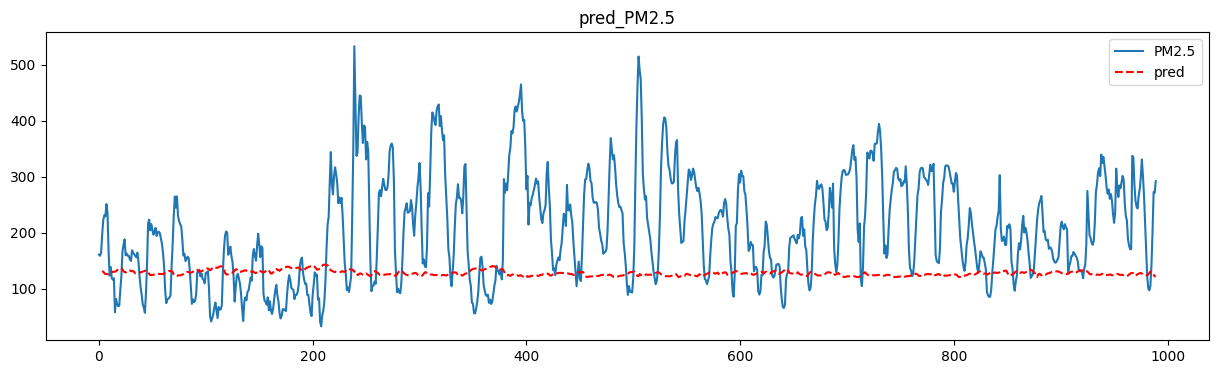

In [53]:
plt.figure(figsize=(15, 4))
plt.plot(test1, label="PM2.5")
plt.plot(result11.index + 3, result11.values, color="red", linestyle="--",label="pred")
plt.title("pred_PM2.5")
plt.legend()

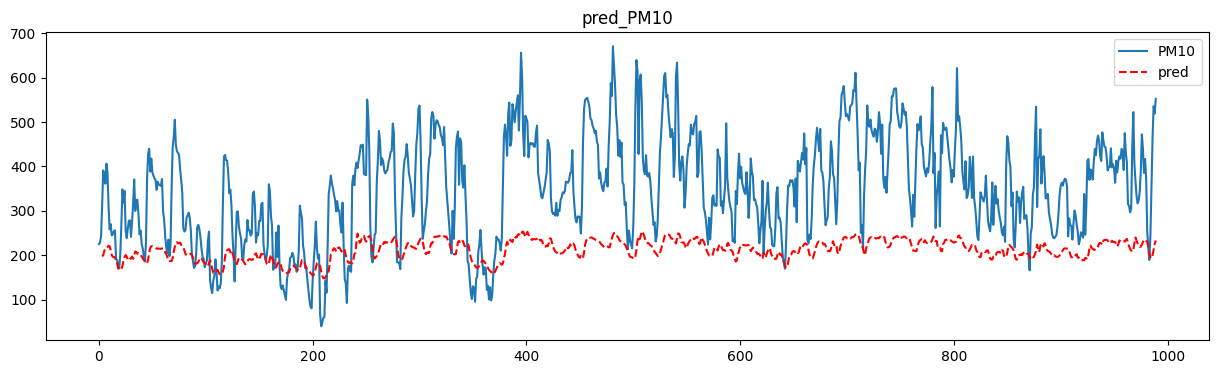

In [54]:
plt.figure(figsize=(15, 4))
plt.plot(test2, label="PM10")
plt.plot(result12.index + 3, result12.values, color="red", linestyle="--", label="pred")
plt.title("pred_PM10")
plt.legend()

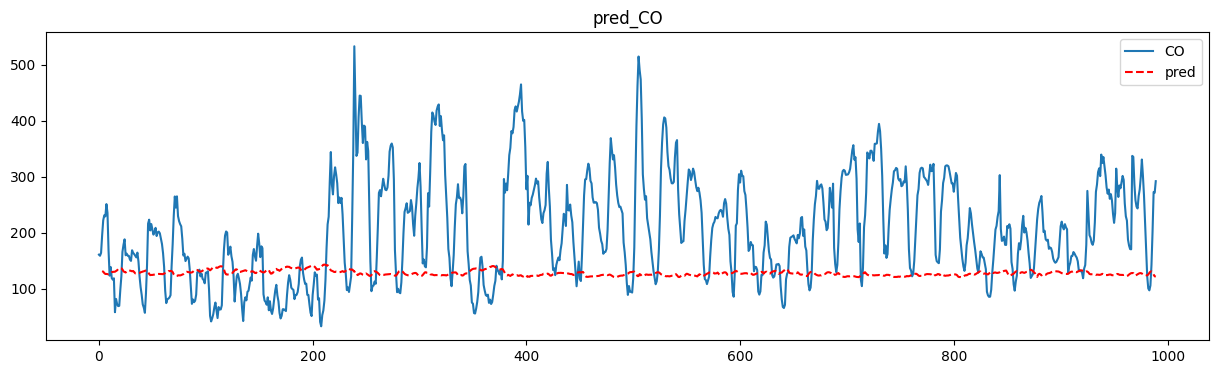

In [55]:
plt.figure(figsize=(15, 4))
plt.plot(test1, label="CO")
plt.plot(result11.index + 3, result11.values, color="red", linestyle="--",label="pred")
plt.title("pred_CO")
plt.legend()

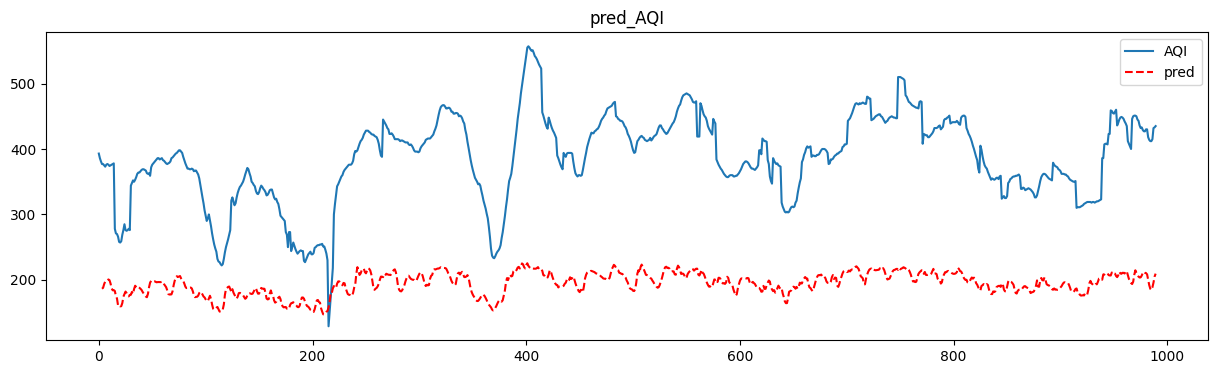

In [63]:
plt.figure(figsize=(15, 4))
plt.plot(test4, label="AQI")
plt.plot(result2.index + 3, result2.values, color="red", linestyle="--",label="pred")
plt.title("pred_AQI")
plt.legend()